In [90]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

import os
#try:
#    os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\celldyn_embedder")
#except FileNotFoundError:
#    os.chdir('C:/Users/Huibert-Jan/Documents/Werk/UMCU/celldyn_embedder')    

import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#import pacmap
import umap
#import trimap

#from scipy.stats import chisquare, chi2_contingency, pearsonr
#from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
#from scipy.spatial import distance
#import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
#from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.decomposition import PCA
#from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness


#from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
#from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
#from sklearn.neighbors import KNeighborsClassifier as KNN
#from sklearn.cluster import KMeans

from hembedder.utils.distance import poincarre_dist, hyperboloid_dist, fractional_distance, Distance
#from hembedder.utils.quality_metrics import CDEmbeddingPerformance
#import numpy.linalg as la
#import torch 

#from numba import njit

#import faiss
import gc




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
celldyn_full = pd.read_feather("L:\laupodteam\AIOS\Bram\data\CellDyn\\artifacts\celldyn_FULL_transformed_miceforest100_df.feather")
meas_columns = [c for c in celldyn_full.columns if ('c_b' in c) | ("COMBO" in c)]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]
celldyn_full.drop(['index'], axis=1, inplace=True)



In [39]:
# metric = 'manhattan'
# metric = poincarre_dist
# metric = hyperboloid_dist
# metric = 'seuclidean'
# metric = 'cosine'
# output_metric='hyperboloid'

In [91]:
metric = 'euclidean'
output_metric='hyperboloid' # 'hyperboloid'

embedder_full = umap.UMAP(n_components=6, metric=metric, output_metric=output_metric, init='spectral',
                          n_neighbors=50, min_dist = 0.0, n_jobs=4, n_epochs=400, low_memory=False, verbose=True)

distancer = Distance()

le_pipe = Pipeline([('scaler', MinMaxScaler()),('distancer', distancer), ('embedder', embedder_full)])

sample_index = celldyn_full.sample(5000).index
le_pipe.fit(celldyn_full.loc[sample_index, meas_columns]) # final_columns  .to_numpy(dtype = np.float32)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at d:\VENVS\Envs\hema_embedder\lib\site-packages\hembedder\utils\distance.py (67)[0m
[1m
File "d:\VENVS\Envs\hema_embedder\lib\site-packages\hembedder\utils\distance.py", line 67:[0m
[1m    def _construct_index_tuple_list(self):
[1m        index_tuple_list = []
[0m        [1m^[0m[0m

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'hembedder.utils.distance.Distance'>[0m


In [84]:
embedded_data = pd.DataFrame(le_pipe.named_steps['embedder'].embedding_,
                        columns=[f'dim_{i+1}' 
                            for i in range(le_pipe.named_steps['embedder'].embedding_.shape[1])]
                            , index=sample_index)

In [85]:
embedded_data['sex'] = celldyn_full.loc[sample_index].gender
embedded_data['age'] = celldyn_full.loc[sample_index].age
embedded_data['study_id'] = celldyn_full.loc[sample_index].studyid_alle_celldyn
embedded_data['analysis_dt'] = celldyn_full.loc[sample_index].asp_dt
embedded_data['sample_dt'] = celldyn_full.loc[sample_index].afname_dt
embedded_data['draw_hour'] = celldyn_full.loc[sample_index].draw_hour


In [86]:
#del celldyn_full, le_pipe
#gc.collect()

In [87]:
#embedded_data.to_feather("L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/embedded_celldyn_FULL_nn50_ndim6_w_labels_w_ratio_mf100.feather")

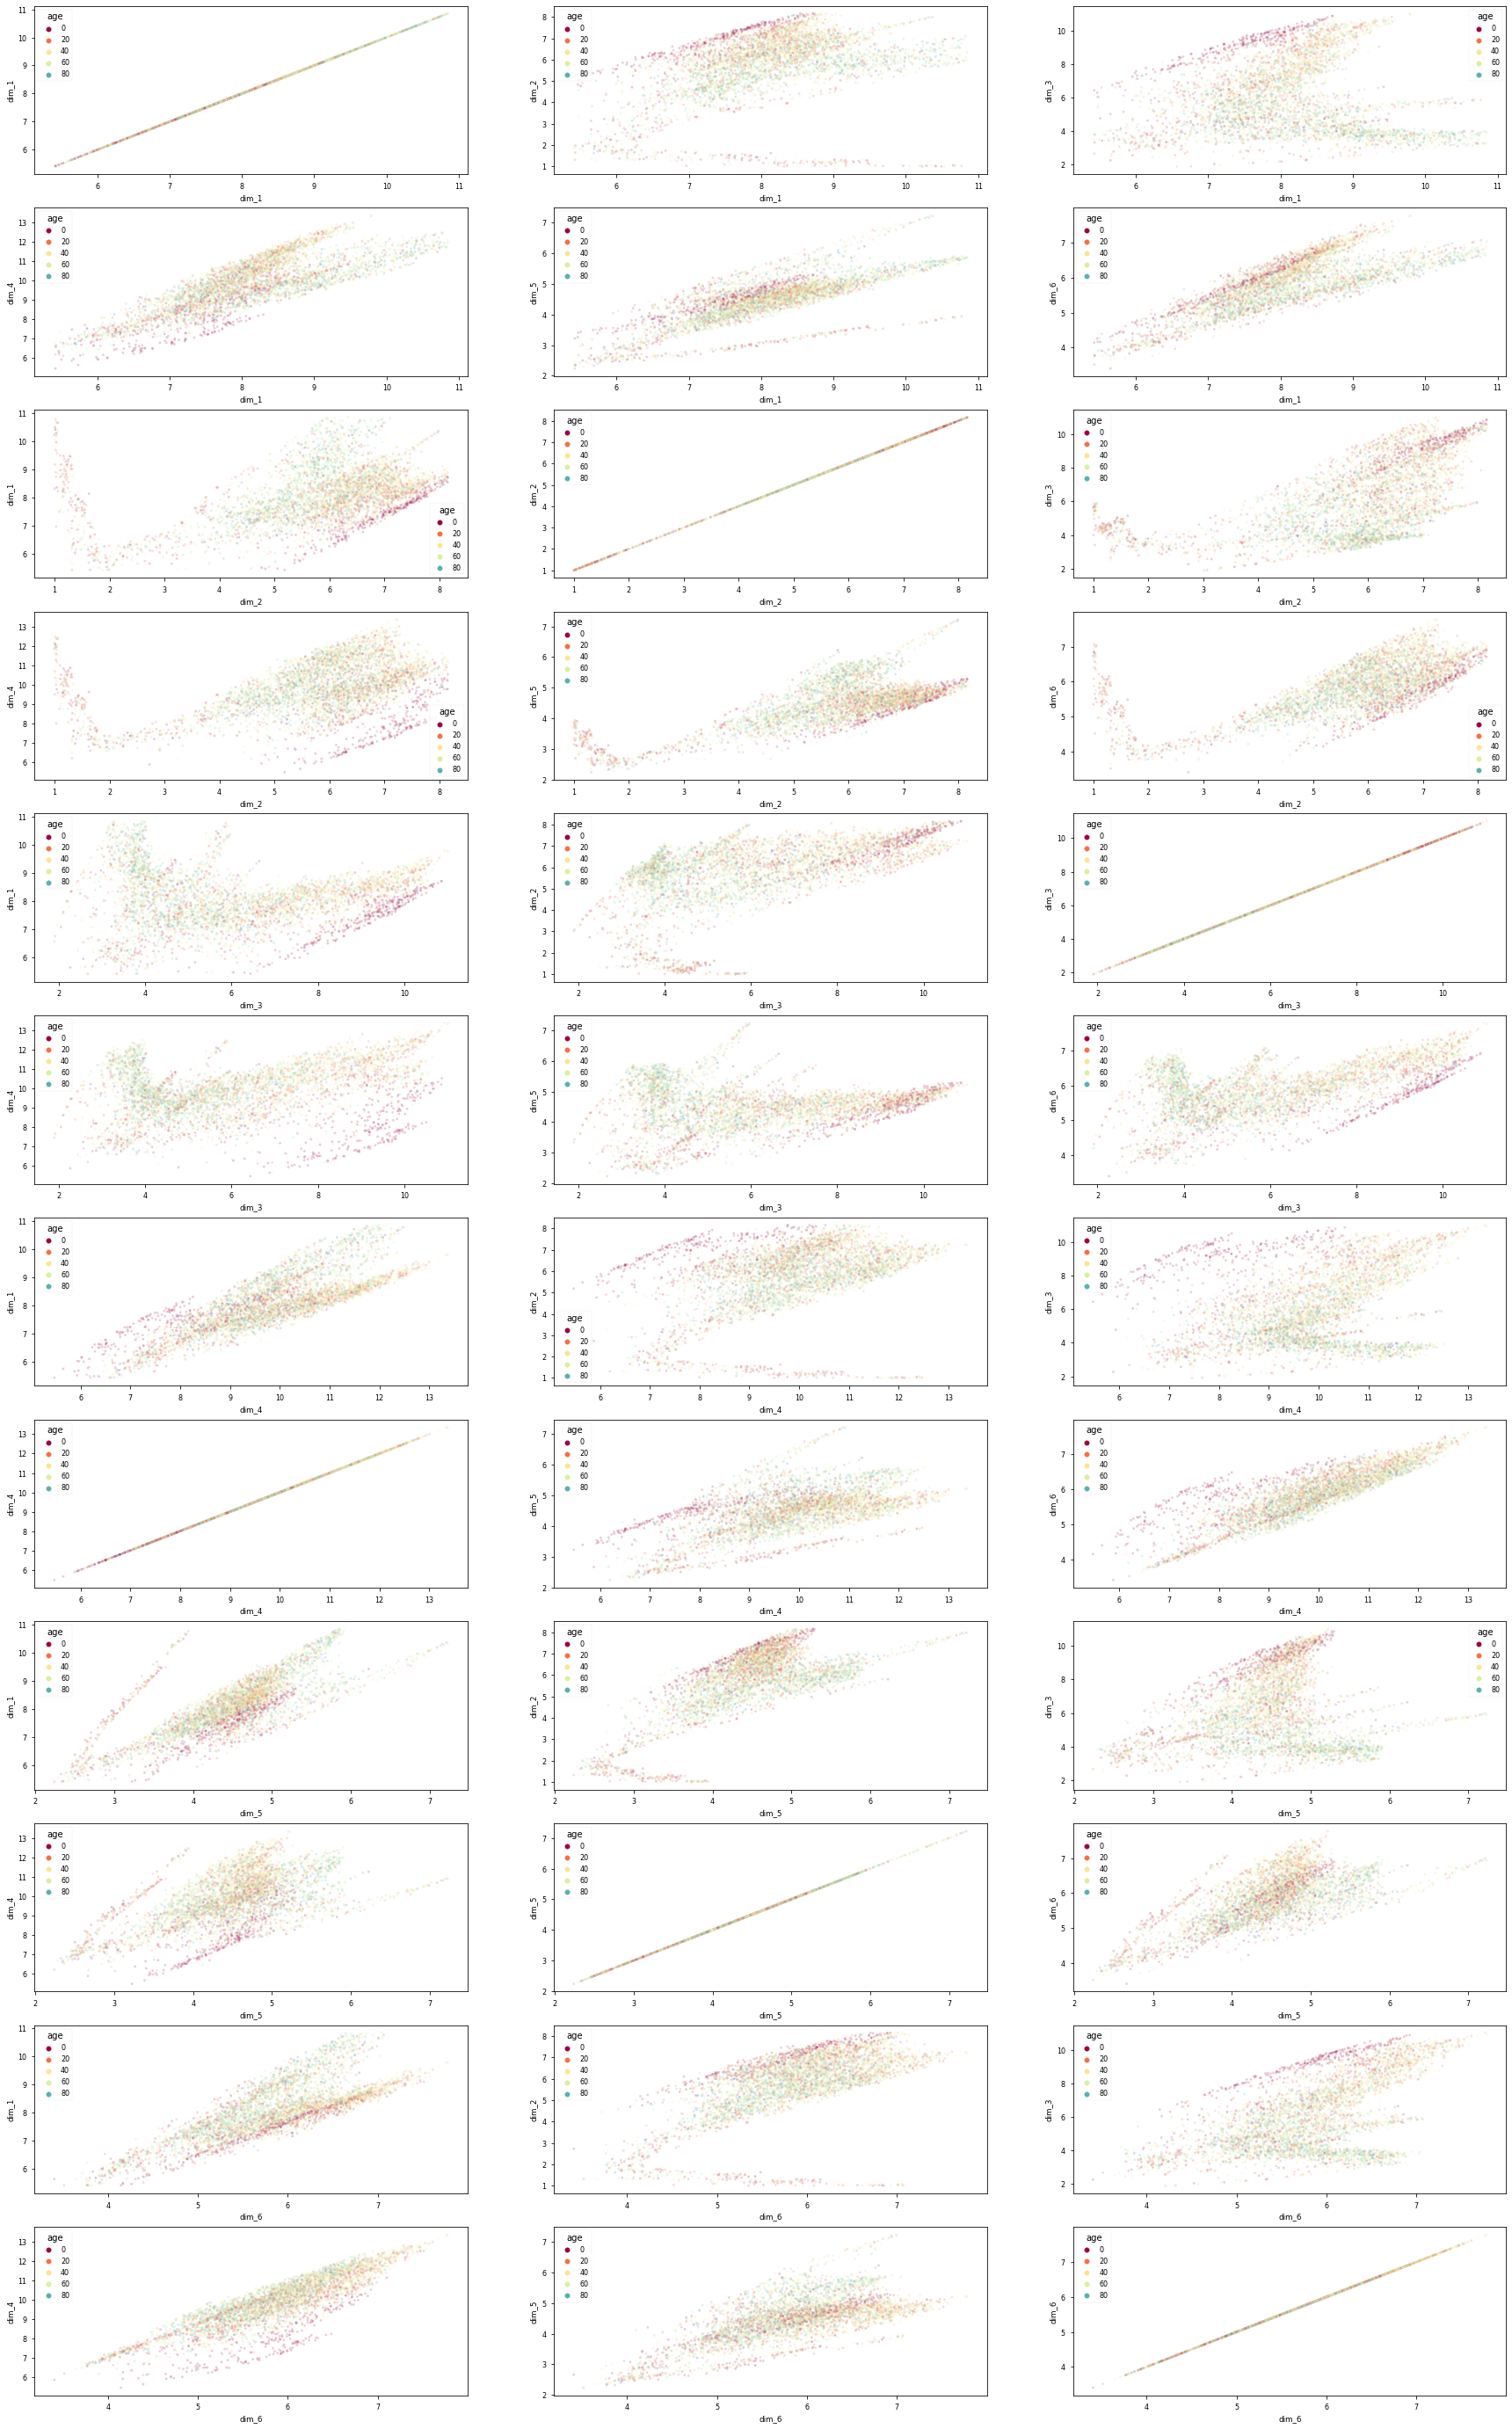

In [88]:
plt.style.use("seaborn-paper")

d1q01 = embedded_data.dim_1.quantile(0.01)
d1q99 = embedded_data.dim_1.quantile(0.99)
d2q01 = embedded_data.dim_2.quantile(0.01)
d2q99 = embedded_data.dim_2.quantile(0.99)

conds = (embedded_data.dim_1>d1q01) & (embedded_data.dim_1<d1q99) & (embedded_data.dim_2>d2q01) & (embedded_data.dim_2<d2q99)

plot_df = embedded_data.loc[conds].sample(min([10000, sum(conds)]))

fig, ax = plt.subplots(12,3,figsize = (30,50))
i,j = 0,0

#sns.color_palette("vlag", as_cmap=True) # icefire, Spectral
for colx in plot_df[[c for c in embedded_data if 'dim' in c]]:
    for coly in plot_df[[c for c in embedded_data if 'dim' in c]]:
        sns.scatterplot(data=plot_df, x=colx, y=coly,  hue='age',
                        s = 8, alpha = 0.2, ax=ax[i,j], palette="Spectral")
        i = i+1 if j == 2 else i
        j = j+1 if j < 2 else 0
        
